In [1]:
import time
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import pickle
import os
import shutil
import random
import copy
import uproot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import random
from sklearn.metrics import plot_confusion_matrix, roc_curve, accuracy_score 
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

In [2]:
METcut=150

In [3]:
treeName="METTree"
dirPath="/home/zhelunli/Desktop/METtrigger/NTUP/"

MCfileNames=["user.cmerlass.410000.PowhegPythiaEvtGen_P2012_ttbar_hdamp172p5_nonallhad.r12400.v030521_bis_TREE.root",
          "user.cmerlass.345058.PowhegPythia8EvtGen_NNPDF3_AZNLO_ggZH125_vvbb.r12488.v040621_TREE.root",
           "user.cmerlass.361021.Pythia8EvtGen_A14NNPDF23LO_jetjet_JZ1W.r12488.v040621_TREE.root"
          ]
MCname=["ttbar","ggZH","JZ1"]
MCfilePaths=[dirPath+s for s in MCfileNames]

dataPath=dirPath+"user.cmerlass.00360026.physics_EnhancedBias.r12408.v030521_bis_TREE.root"
saveDir="/home/zhelunli/Desktop/METtrigger/plots"

if os.path.exists(saveDir):
    shutil.rmtree(saveDir)
    os.makedirs(saveDir)
else:
    os.makedirs(saveDir)

algList=["tcpufit","cell","trkmht","pfopufit","mhtpufit_em_subjesgscIS","mhtpufit_pf_subjesgscIS",
        "pfsum_vssk","pfsum_cssk","L1"]

truthList=["NonIntPlusIntMuons","NonIntMinusIntMuons","NonInt","IntMuons","Int"]
singleList=["ActualInteractionsPerCrossing","MCEventWeight","L1_XE50.isPassed","HLT_xe100_pfopufit_L1XE50.isPassed","HLT_xe110_tcpufit_L1XE50.isPassed","HLT_xe100_trkmht_xe85_tcpufit_xe65_cell_L1XE50.isPassed"]
variableList=[]

metList=[]
metPhiTrainList=[]
for alg in algList:
    variableList.append(alg+".met")
    variableList.append(alg+".phi")
    variableList.append(alg+".sumet")
    metList.append(alg+".met")
    metPhiTrainList.append(alg+".met")
    metPhiTrainList.append(alg+".phi")
    metPhiTrainList.append(alg+".sumet")
    
truthVarList=[]
for var in truthList:
    truthVarList.append("Truth."+var+".met")
    truthVarList.append("Truth."+var+".mpx")
    truthVarList.append("Truth."+var+".mpy")

def getDF(tree,processName,normWeight):
    input_tree=uproot.open(tree)
    df=input_tree.arrays(filter_name=variableList[0],library="pd")
    for i in range(1,len(variableList)):
        df=df.join(input_tree.arrays(filter_name=variableList[i],library="pd"))

    for i in range(0,len(truthVarList)):
        df=df.join(input_tree.arrays(filter_name=truthVarList[i],library="pd"))

    for i in range(0,len(singleList)):
        df=df.join(input_tree.arrays(filter_name=singleList[i],library="pd"))

    #convert to GeV
    df[variableList]=df[variableList]/1000.0
    df[truthVarList]=df[truthVarList]/1000.0
    #Setting truth MET to be The GIVEN MET for comparison 
    df['MET']=df['Truth.NonIntMinusIntMuons.met']
    df['process']=processName
    #normalize weight
    if normWeight:
        df['weight']=df['MCEventWeight']/df['MCEventWeight'].sum()
    else:
        df['weight']=df['MCEventWeight']
    print(processName," nUnweightedEvents=",df.shape[0])
    return df

def getDataDF(tree,processName):
    input_tree=uproot.open(tree)
    df=input_tree.arrays(filter_name=variableList[0],library="pd")
    for i in range(1,len(variableList)):
        df=df.join(input_tree.arrays(filter_name=variableList[i],library="pd"))
        
    df=df.join(input_tree.arrays(filter_name="Reco.met",library="pd")/1000.0)
    df=df.join(input_tree.arrays(filter_name="EBWeight",library="pd")/1000.0)
    for i in range(0,len(singleList)):
        df=df.join(input_tree.arrays(filter_name=singleList[i],library="pd"))

    #convert to GeV
    df[variableList]=df[variableList]/1000.0
    #Setting truth MET to be The GIVEN MET for comparison 
    df['MET']=df['Reco.met']
    df['process']=processName
    df['weight']=df['EBWeight']
    
    print(processName," nUnweightedEvents=",df.shape[0])
    return df

In [4]:
normWeight=True
df=getDF(MCfilePaths[0]+":"+treeName,MCname[0],normWeight)
    
for i in range(1,len(MCfilePaths)):
    df=df.append(getDF(MCfilePaths[i]+":"+treeName,MCname[i],normWeight))


ttbar  nUnweightedEvents= 100000
ggZH  nUnweightedEvents= 100000
JZ1  nUnweightedEvents= 100000


In [5]:
data_df=getDataDF(dataPath+":"+treeName,"EB")

EB  nUnweightedEvents= 47339


In [6]:
df["isSignal"]=0
df.loc[df["Truth.NonIntMinusIntMuons.met"]>150,"isSignal"]=1
y=df.pop("isSignal")

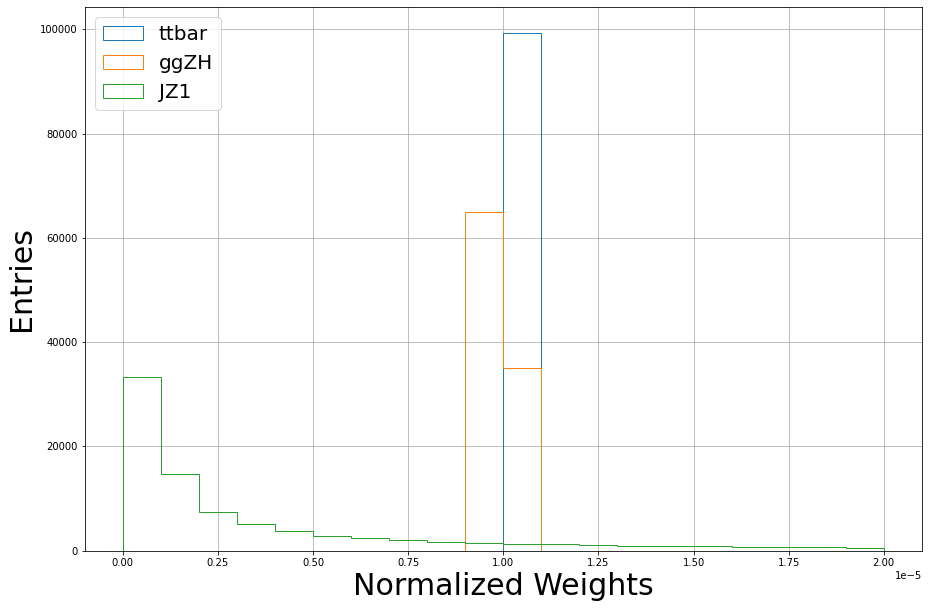

In [7]:
fig=plt.figure(0,figsize=(15,10))
df[df['process']=='ttbar']['weight'].hist(bins=np.arange(0,0.00002,0.000001),histtype='step',label='ttbar')
df[df['process']=='ggZH']['weight'].hist(bins=np.arange(0,0.00002,0.000001),histtype='step',label='ggZH')
df[df['process']=='JZ1']['weight'].hist(bins=np.arange(0,0.00002,0.000001),histtype='step',label='JZ1')
plt.legend()
plt.ylabel("Entries",size=30)
plt.xlabel("Normalized Weights",size=30)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.legend(loc=2,prop={'size': 20})
#plt.text(1.2e-5,6e4,r'Normalized weights',size=30)
fig.savefig(saveDir+"/weights.pdf")
plt.show()

In [8]:
#All
#X_trainAll, X_testAll, y_trainAll, y_testAll = train_test_split(df, y, test_size=0.5, random_state=0)
#X_validAll, X_testAll, y_validAll, y_testAll = train_test_split(X_testAll, y_testAll, test_size=0.5, random_state=0)
X_trainAll, X_validAll, y_trainAll, y_validAll = train_test_split(df, y, test_size=0.5, random_state=0)

#Training on those which passed L1
X_train=X_trainAll[X_trainAll["L1_XE50.isPassed"]==1].copy()
X_valid=X_validAll[X_validAll["L1_XE50.isPassed"]==1].copy()
#X_test=X_testAll[X_testAll["L1_XE50.isPassed"]==1].copy()

y_train=y_trainAll[X_trainAll["L1_XE50.isPassed"]==1].copy()
y_valid=y_validAll[X_validAll["L1_XE50.isPassed"]==1].copy()
#y_test=y_testAll[X_testAll["L1_XE50.isPassed"]==1].copy()

dataPostL1=data_df[data_df["L1_XE50.isPassed"]==1]


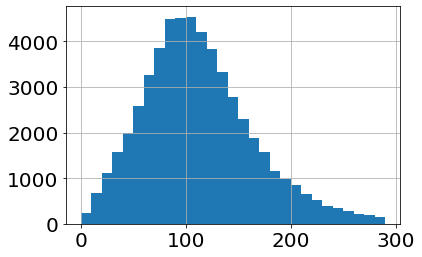

In [9]:
X_train['pfsum_cssk.met'].hist(bins=np.arange(0,300,10))
plt.show()

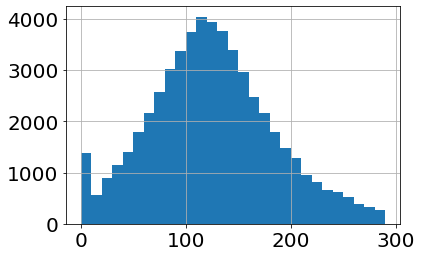

In [10]:
#truth
X_train['MET'].hist(bins=np.arange(0,300,10))
plt.show()

Logistic Regression Classifier

In [11]:
time0=time.time()
clf_logi = LogisticRegression(random_state=0,max_iter=500000).fit(X_train[metPhiTrainList], y_train,sample_weight=X_train['weight'])
time1=time.time()
print("training time : ",time1-time0)
print('training score: ',clf_logi.score(X_train[metPhiTrainList], y_train,sample_weight=X_train['weight']))
print('validation score: ',clf_logi.score(X_valid[metPhiTrainList], y_valid,sample_weight=X_valid['weight']))

training time :  23.285550117492676
training score:  0.8743456345631504
validation score:  0.8701370196185039


In [12]:
time0=time.time()
reg = LinearRegression().fit(X_train[metPhiTrainList], X_train['MET'],sample_weight=abs(X_train['weight']))
time1=time.time()
print("training time : ",time1-time0)
print('training score: ',reg.score(X_train[metPhiTrainList], X_train['MET'],sample_weight=X_train['weight']))
print('validation score: ',reg.score(X_valid[metPhiTrainList], X_valid['MET'],sample_weight=X_valid['weight']))

training time :  0.2207019329071045
training score:  0.811360663261009
validation score:  0.8115258774890199


In [13]:
regValidPredict=reg.predict(X_valid[metPhiTrainList])

Neural Network

In [14]:
print(tf.__version__)

2.5.0


In [76]:
def build_and_compile_singleLayer(data):
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-3,
    decay_steps=100,
    decay_rate=0.99)
    
    input1 = Input(data.shape[1])
    #norm = preprocessing.Normalization()
    #norm.adapt(data)
    #lay1=norm(input1)
    out = layers.Dense(1)(input1)
    model = Model(inputs=input1, outputs=out)

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule))
    return model

def build_and_compile_model(data):
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-3,
    decay_steps=100,
    decay_rate=0.99)
    
    input1 = Input(data.shape[1])
    #norm = preprocessing.Normalization()
    #norm.adapt(data)
    #lay1=norm(input1)
    lay2 = layers.Dense(30)(input1)
    lay3 = layers.Dense(60)(lay2)
    lay4 = layers.Dense(60)(lay3)
    out = layers.Dense(1)(lay4)
    model = Model(inputs=input1, outputs=out)

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule))
    return model

def build_and_compile_DNNclassfyModel(norm):
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-3,
    decay_steps=100,
    decay_rate=0.99)

    model = keras.Sequential([
        norm,
        #layers.Dense(10, activation='relu',kernel_regularizer=regularizers.l2(0.0001)),
        #layers.Dropout(0.2),
        layers.Dense(30, activation='relu'),
        layers.Dense(60, activation='relu'),
        layers.Dense(60, activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy', metrics=['accuracy'],
                optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule))
    return model

In [16]:
%%time
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(X_train[metPhiTrainList]))
dnn_model = build_and_compile_model(X_train[metPhiTrainList])
dnn_model.summary()
history = dnn_model.fit(
    X_train[metPhiTrainList], X_train['MET'],
    validation_data=(X_valid[metPhiTrainList], X_valid['MET']),
    verbose=1, epochs=50)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 27)]              0         
_________________________________________________________________
dense (Dense)                (None, 30)                840       
_________________________________________________________________
dense_1 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                3660      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 61        
Total params: 6,421
Trainable params: 6,421
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1726/1726 [==============================] - 4s 2ms/step - loss: 29.5182 - val_loss: 25.3604
Epoch 2/50
1726/1726 

In [17]:
def plot_loss(history,name):
    fig=plt.figure(2,figsize=(15,10))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch',size=30)
    plt.ylabel('Error [MPG]',size=30)
    plt.rc('xtick', labelsize=20) 
    plt.rc('ytick', labelsize=20) 
    #plt.text(20,24,r'MC JZ1+$t\overline{t}$ nonAllHad+ggZH125;L1XE50',size=20)
    plt.legend(loc='best',prop={'size': 20})
    plt.grid(True)
    plt.show()
    fig.savefig(saveDir+"/"+name+".pdf")

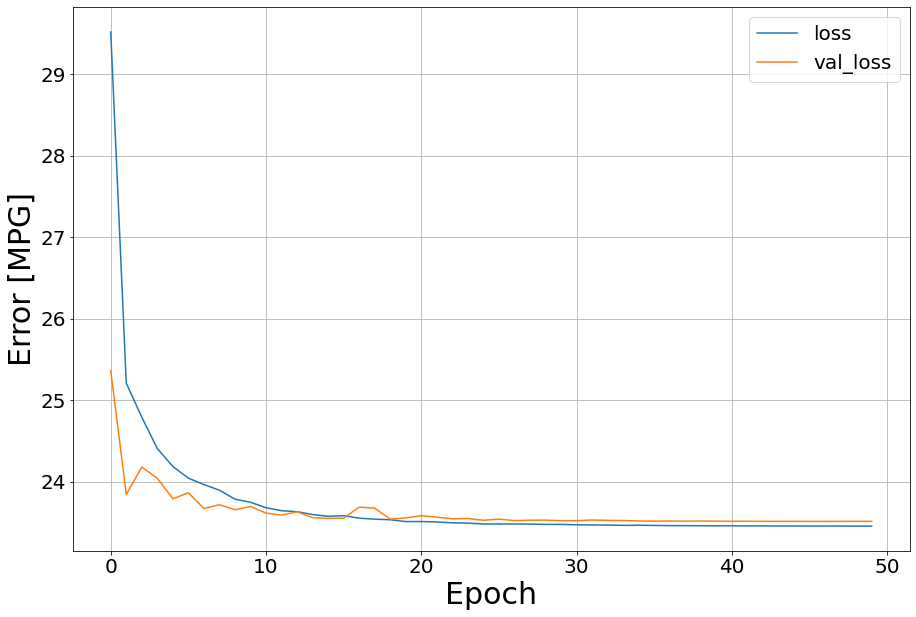

In [18]:
plot_loss(history,"NNhistory")

In [19]:
dnnPredict=dnn_model.predict(X_valid[metPhiTrainList]).flatten()


In [20]:
JZ1xValid=X_valid[X_valid['process']=='JZ1']
JZ1yValid=y_valid[X_valid['process']=='JZ1']
JZ1xValidAll=X_validAll[X_validAll['process']=='JZ1']
JZ1yValidAll=y_validAll[X_validAll['process']=='JZ1']

ttZHxTrain=X_train[(X_train['process']=='ttbar')|(X_train['process']=='ggZH')]
ttZHyTrain=y_train[(X_train['process']=='ttbar')|(X_train['process']=='ggZH')]

ttZHxValid=X_valid[(X_valid['process']=='ttbar')|(X_valid['process']=='ggZH')]
ttZHyValid=y_valid[(X_valid['process']=='ttbar')|(X_valid['process']=='ggZH')]
ttZHxValidAll=X_validAll[(X_validAll['process']=='ttbar')|(X_validAll['process']=='ggZH')]
ttZHyValidAll=y_validAll[(X_validAll['process']=='ttbar')|(X_validAll['process']=='ggZH')]

Evaluation

In [21]:
def checkPR(alg,cut,X_valid,y_valid):
    passedX=X_valid[X_valid[alg]>=cut]
    passedY=y_valid[X_valid[alg]>=cut]
    fpr=passedX[passedY==0]['weight'].sum()/X_valid[y_valid==0]['weight'].sum()
    tpr=passedX[passedY==1]['weight'].sum()/X_valid[y_valid==1]['weight'].sum()
    return fpr,tpr
def checkPredictPR(Predict,cut,X_valid,y_valid):
    passedX=X_valid[Predict>=cut]
    passedY=y_valid[Predict>=cut]
    fpr=passedX[passedY==0]['weight'].sum()/X_valid[y_valid==0]['weight'].sum()
    tpr=passedX[passedY==1]['weight'].sum()/X_valid[y_valid==1]['weight'].sum()
    return fpr,tpr

def weightedStd(data,weights):
    if(len(weights)>0):
        weightedMean=np.average(data,weights=weights)
        diff=(data-weightedMean)
        std=np.sqrt((weights*diff*diff).sum()/weights.sum())
        #print("mean =",weightedMean)
        #print("std=",std)
    else:
        std=0
        
    return std
    
def getNormReso(alg,low,high,X_valid):
    passedX=X_valid[(X_valid[alg]>=low)&(X_valid[alg]<high)]
    METdiff=passedX['MET']-passedX[alg]
    return weightedStd(METdiff,passedX['weight'])

def getNormPredReso(Predict,low,high,X_valid):
    passedX=X_valid[(Predict>=low)&(Predict<high)]
    METdiff=passedX['MET']-Predict[(Predict>=low)&(Predict<high)]
    return weightedStd(METdiff,passedX['weight'])

In [22]:
fpr,tpr,thresholds=roc_curve(y_valid,clf_logi.predict_proba(X_valid[metPhiTrainList]).T[1],sample_weight=X_valid['weight'])

tc_fpr=[]
tc_tpr=[]

pfo_fpr=[]
pfo_tpr=[]
pfo_reso=[]

trkmht_fpr=[]
trkmht_tpr=[]
trkmht_reso=[]

reg_fpr=[]
reg_tpr=[]
reg_reso=[]

dnn_fpr=[]
dnn_tpr=[]
dnn_reso=[]

cutBins=[]
step=5
for i in range(80):
    cut=0+i*step
    cutBins.append(cut)
    
    pr=checkPR("tcpufit.met",cut,X_valid,y_valid)
    tc_fpr.append(pr[0])
    tc_tpr.append(pr[1])
    
    pr=checkPR("pfopufit.met",cut,X_valid,y_valid)
    pfo_fpr.append(pr[0])
    pfo_tpr.append(pr[1])
    pfo_reso.append(getNormReso("pfopufit.met",cut,cut+step,X_valid))
    
    pr=checkPR("trkmht.met",cut,X_valid,y_valid)
    trkmht_fpr.append(pr[0])
    trkmht_tpr.append(pr[1])
    trkmht_reso.append(getNormReso("trkmht.met",cut,cut+step,X_valid))
    
    pr=checkPredictPR(regValidPredict,cut,X_valid,y_valid)
    reg_fpr.append(pr[0])
    reg_tpr.append(pr[1])
    reg_reso.append(getNormPredReso(regValidPredict,cut,cut+step,X_valid))
    
    pr=checkPredictPR(dnnPredict,cut,X_valid,y_valid)
    dnn_fpr.append(pr[0])
    dnn_tpr.append(pr[1])
    dnn_reso.append(getNormPredReso(dnnPredict,cut,cut+step,X_valid))

In [23]:
dnn_bkgRate=[]
dnn_150Eff=[]

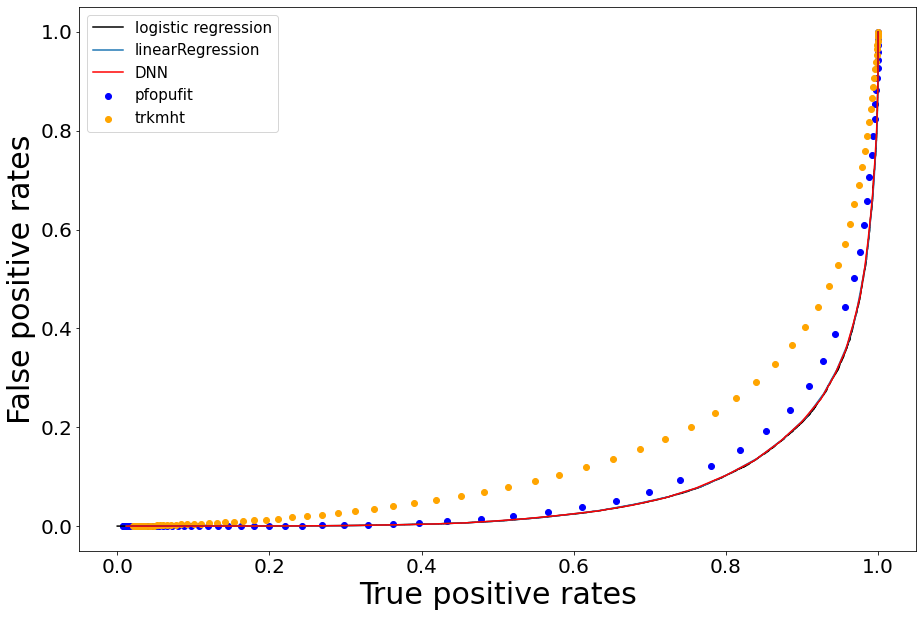

In [24]:
fig=plt.figure(2,figsize=(15,10))
plt.scatter(pfo_tpr,pfo_fpr,label='pfopufit',color='b')
plt.scatter(trkmht_tpr,trkmht_fpr,label='trkmht',color='orange')
plt.plot(tpr, fpr,label='logistic regression',color='k')
plt.plot(reg_tpr, reg_fpr,label='linearRegression')
plt.plot(dnn_tpr, dnn_fpr,label='DNN',color='r')
plt.ylabel("False positive rates",size=30)
plt.xlabel("True positive rates",size=30)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
#plt.text(0.0,0.6,r'MC JZ1+$t\overline{t}$ nonAllHad+ggZH125;L1XE50',size=20)
#plt.yscale('log')
#plt.xlim(0.94,1.0)
plt.legend(loc='best',prop={'size': 15})
plt.show()
fig.savefig(saveDir+"/ROC_.pdf")
plt.close(fig)

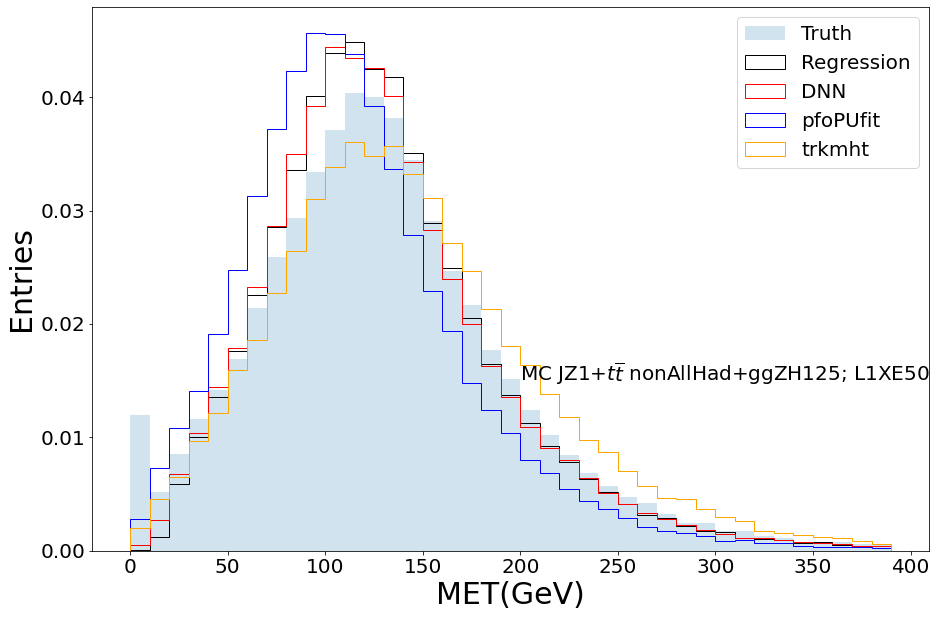

In [25]:
fig=plt.figure(3,figsize=(15,10))
bins=np.arange(0,400,10)
plt.hist(X_valid['MET'],bins=bins,weights=X_valid['weight'],label='Truth',alpha=0.2)
plt.hist(regValidPredict,bins=bins,weights=X_valid['weight'],histtype='step',label='Regression',color='k')
plt.hist(dnnPredict,bins=bins,weights=X_valid['weight'],histtype='step',label='DNN',color='r')
plt.hist(X_valid["pfopufit.met"],bins=bins,weights=X_valid['weight'],histtype='step',label='pfoPUfit',color='b')
plt.hist(X_valid["trkmht.met"],bins=bins,weights=X_valid['weight'],histtype='step',label='trkmht',color='orange')
plt.xlabel("MET(GeV)",size=30)
plt.ylabel("Entries",size=30)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.text(200,0.015,r'MC JZ1+$t\overline{t}$ nonAllHad+ggZH125; L1XE50',size=20)
#plt.yscale('log')
#plt.xlim(0.5,1.0)
plt.legend(loc='best',prop={'size': 20})
plt.show()
fig.savefig(saveDir+"/MET.pdf")
plt.close(fig)

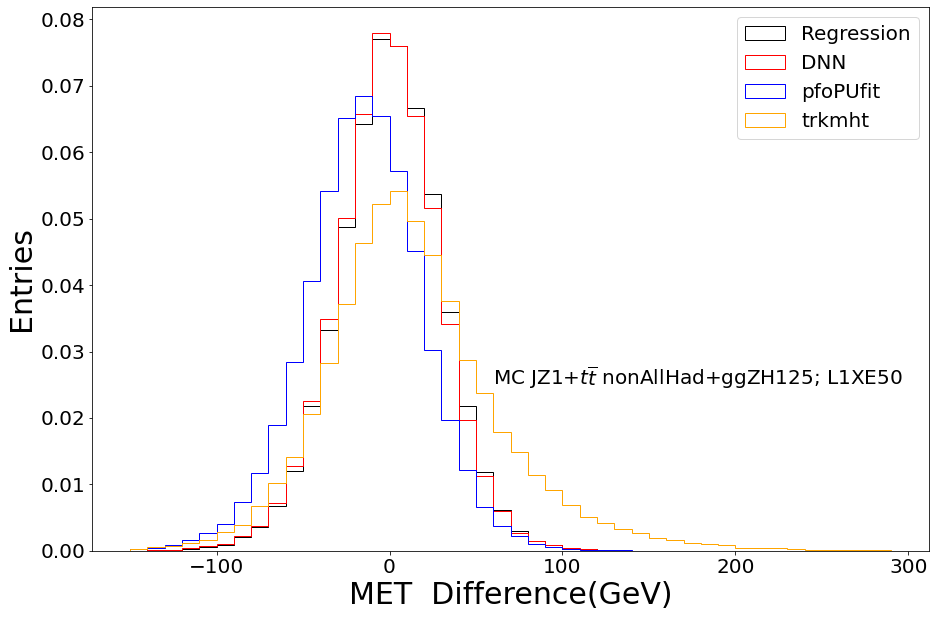

In [26]:
fig=plt.figure(4,figsize=(15,10))
bins=np.arange(-150,300,10)
plt.hist(regValidPredict-X_valid['MET'],bins=bins,weights=X_valid['weight'],histtype='step',label='Regression',color='k')
plt.hist(dnnPredict-X_valid['MET'],bins=bins,weights=X_valid['weight'],histtype='step',label='DNN',color='r')
plt.hist(X_valid["pfopufit.met"]-X_valid['MET'],bins=bins,weights=X_valid['weight'],histtype='step',label='pfoPUfit',color='b')
plt.hist(X_valid["trkmht.met"]-X_valid['MET'],bins=bins,weights=X_valid['weight'],histtype='step',label='trkmht',color='orange')
plt.xlabel("MET  Difference(GeV)",size=30)
plt.ylabel("Entries",size=30)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.text(60,0.025,r'MC JZ1+$t\overline{t}$ nonAllHad+ggZH125; L1XE50',size=20)
plt.legend(loc='best',prop={'size': 20})
plt.show()
fig.savefig(saveDir+"/MET.pdf")
plt.close(fig)

In [27]:
np.array(regValidPredict-X_valid['MET'])[0]

8.998301187757647

In [28]:
print('reg')
weightedStd(regValidPredict-X_valid['MET'],X_valid['weight'])
print('DNN')
weightedStd(dnnPredict-X_valid['MET'],X_valid['weight'])
print('pfo')
weightedStd(X_valid["pfopufit.met"]-X_valid['MET'],X_valid['weight'])
print('trkmht')
weightedStd(X_valid["trkmht.met"]-X_valid['MET'],X_valid['weight'])

reg
DNN
pfo
trkmht


51.0700795827442

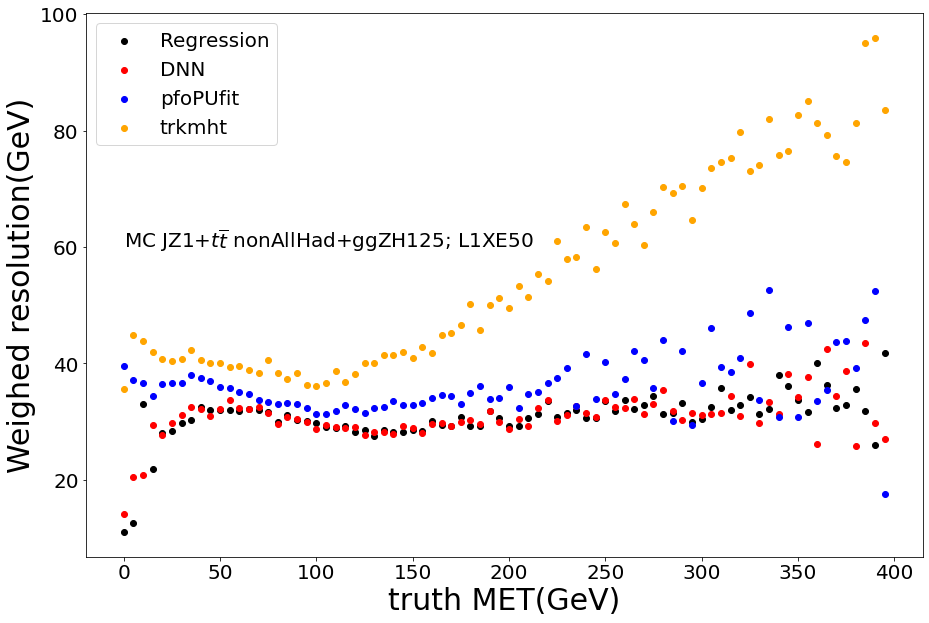

In [29]:
fig=plt.figure(5,figsize=(15,10))
bins=np.arange(0,300,10)
plt.scatter(cutBins,reg_reso,label='Regression',color='k')
plt.scatter(cutBins,dnn_reso,label='DNN',color='r')
plt.scatter(cutBins,pfo_reso,label='pfoPUfit',color='b')
plt.scatter(cutBins,trkmht_reso,label='trkmht',color='orange')
plt.xlabel("truth MET(GeV)",size=30)
plt.ylabel("Weighed resolution(GeV)",size=30)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.text(0,60.0,r'MC JZ1+$t\overline{t}$ nonAllHad+ggZH125; L1XE50',size=20)
plt.legend(loc='best',prop={'size': 20})
plt.show()
fig.savefig(saveDir+"/WeightedReso.pdf")
plt.close(fig)

New rates and efficiencies

In [30]:
cellCut=55
def checkRates(y,x,alg,cut):
    #check fpr only in JZ1, compute rates w.r.t L1XE50 event:
    passedy=y[(y[alg]>=cut)&(y['cell.met']>cellCut)]
    x150=x[x['MET']>=METcut]
    passedx=x[(x[alg]>=cut)&(x['MET']>=METcut)&(x['cell.met']>cellCut)]
    fpr=passedy['weight'].sum()/y['weight'].sum()
    tpr=passedx['weight'].sum()/x150['weight'].sum()
    
    return fpr,tpr
def checkRegressionRates(Predict_y,y,Predict_x,x,cut):
    #check fpr only in JZ1, compute rates w.r.t L1XE50 event:
    passedy=y[(Predict_y>=cut)&(y['cell.met']>cellCut)]
    x150=x[x['MET']>=METcut]
    passedx=x[(Predict_x>=cut)&(x['MET']>=METcut)&(x['cell.met']>cellCut)]
    fpr=passedy['weight'].sum()/y['weight'].sum()
    tpr=passedx['weight'].sum()/x150['weight'].sum()
    return fpr,tpr


def checkClassifierRates(Predict_JZ1,Predict_ttZH,cut):
    #check fpr only in JZ1, compute rates w.r.t L1XE50 event:
    passedJZ1=JZ1xValid[(Predict_JZ1>=cut)&(y['cell.met']>cellCut)]
    ttZH150=ttZHxValid[ttZHxValid['MET']>=METcut]
    passedttZH=ttZHxValid[(Predict_ttZH>=cut)&(ttZHxValid['MET']>=METcut)&(ttZHxValid['cell.met']>cellCut)]
    
    fpr=passedJZ1['weight'].sum()/JZ1xValid['weight'].sum()
    tpr=passedttZH['weight'].sum()/ttZH150['weight'].sum()
    return fpr,tpr

dnn_ttZHpredict=dnn_model.predict(ttZHxValid[metPhiTrainList]).flatten()
dnn_JZ1predict=dnn_model.predict(JZ1xValid[metPhiTrainList]).flatten()
dnn_EBpredict=dnn_model.predict(dataPostL1[metPhiTrainList]).flatten()

reg_ttZHpredict=reg.predict(ttZHxValid[metPhiTrainList]).flatten()
reg_JZ1predict=reg.predict(JZ1xValid[metPhiTrainList]).flatten()
reg_EBpredict=reg.predict(dataPostL1[metPhiTrainList]).flatten()

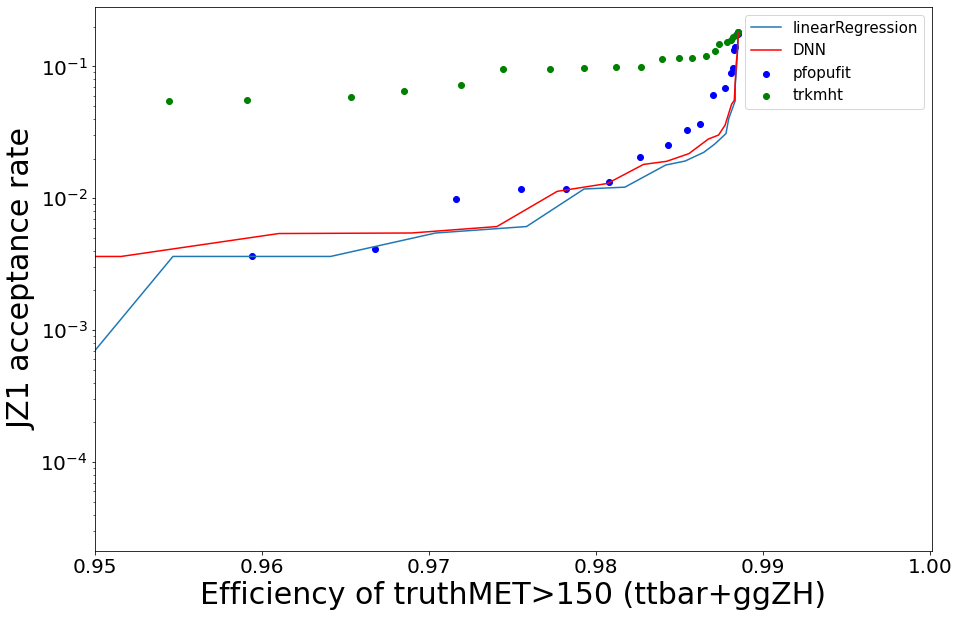

In [31]:
tc_fpr=[]
tc_tpr=[]

pfo_fpr=[]
pfo_tpr=[]

trkmht_fpr=[]
trkmht_tpr=[]

reg_fpr=[]
reg_tpr=[]

dnn_fpr=[]
dnn_tpr=[]

dnn_ttZH_fpr=[]
dnn_ttZH_tpr=[]

cutBins=[]
step=5
for i in range(80):
    cut=0+i*step
    cutBins.append(cut)
    pr=checkRates(JZ1xValid,ttZHxValid,"tcpufit.met",cut)
    tc_fpr.append(pr[0])
    tc_tpr.append(pr[1])
    
    pr=checkRates(JZ1xValid,ttZHxValid,"trkmht.met",cut)
    trkmht_fpr.append(pr[0])
    trkmht_tpr.append(pr[1])
    
    pr=checkRates(JZ1xValid,ttZHxValid,"pfopufit.met",cut)
    pfo_fpr.append(pr[0])
    pfo_tpr.append(pr[1])
    
    pr=checkRegressionRates(reg_JZ1predict,JZ1xValid,reg_ttZHpredict,ttZHxValid,cut)
    reg_fpr.append(pr[0])
    reg_tpr.append(pr[1])
    
    pr=checkRegressionRates(dnn_JZ1predict,JZ1xValid,dnn_ttZHpredict,ttZHxValid,cut)
    dnn_fpr.append(pr[0])
    dnn_tpr.append(pr[1])

    
#probability loop:
#dnnClass_tpr=[]
#dnnClass_fpr=[]
#step=0.01
#for i in range(100):
#    cut=0+i*step
#    pr=checkRegressionRates(dnnClass_JZ1predict,dnnClass_ttZHpredict,cut)
#    dnnClass_tpr.append(pr[0])
#    dnnClass_fpr.append(pr[1])

fig=plt.figure(2,figsize=(15,10))
plt.scatter(pfo_tpr,pfo_fpr,label='pfopufit',color='b')
plt.scatter(trkmht_tpr,trkmht_fpr,label='trkmht',color='g')
plt.plot(reg_tpr, reg_fpr,label='linearRegression')
plt.plot(dnn_tpr, dnn_fpr,label='DNN',color='r')
plt.ylabel("JZ1 acceptance rate",size=30)
plt.xlabel("Efficiency of truthMET>150 (ttbar+ggZH)",size=30)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
#plt.text(0.945,0.6,r'MC samples with Events passed L1XE50',size=20)
plt.yscale('log')
plt.xlim(0.95,1.0001)
plt.legend(loc='best',prop={'size': 15})
plt.show()
fig.savefig(saveDir+"/ROC_separate.pdf")
plt.close(fig)

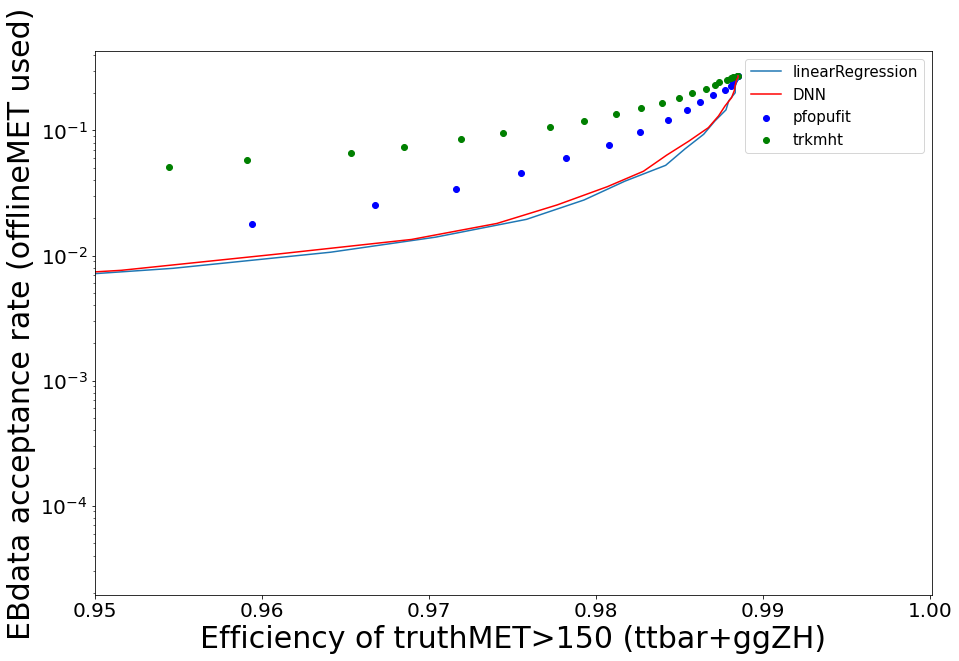

In [32]:
tc_fpr=[]
tc_tpr=[]

pfo_fpr=[]
pfo_tpr=[]

trkmht_fpr=[]
trkmht_tpr=[]

reg_fpr=[]
reg_tpr=[]

dnn_fpr=[]
dnn_tpr=[]

dnn_ttZH_fpr=[]
dnn_ttZH_tpr=[]

cutBins=[]
step=5
for i in range(80):
    cut=0+i*step
    cutBins.append(cut)
    pr=checkRates(dataPostL1,ttZHxValid,"tcpufit.met",cut)
    tc_fpr.append(pr[0])
    tc_tpr.append(pr[1])
    
    pr=checkRates(dataPostL1,ttZHxValid,"trkmht.met",cut)
    trkmht_fpr.append(pr[0])
    trkmht_tpr.append(pr[1])
    
    pr=checkRates(dataPostL1,ttZHxValid,"pfopufit.met",cut)
    pfo_fpr.append(pr[0])
    pfo_tpr.append(pr[1])
    
    pr=checkRegressionRates(reg_EBpredict,dataPostL1,reg_ttZHpredict,ttZHxValid,cut)
    reg_fpr.append(pr[0])
    reg_tpr.append(pr[1])
    
    pr=checkRegressionRates(dnn_EBpredict,dataPostL1,dnn_ttZHpredict,ttZHxValid,cut)
    dnn_fpr.append(pr[0])
    dnn_tpr.append(pr[1])


fig=plt.figure(2,figsize=(15,10))
plt.scatter(pfo_tpr,pfo_fpr,label='pfopufit',color='b')
plt.scatter(trkmht_tpr,trkmht_fpr,label='trkmht',color='g')
plt.plot(reg_tpr, reg_fpr,label='linearRegression')
plt.plot(dnn_tpr, dnn_fpr,label='DNN',color='r')
plt.ylabel("EBdata acceptance rate (offlineMET used)",size=30)
plt.xlabel("Efficiency of truthMET>150 (ttbar+ggZH)",size=30)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
#plt.text(0.945,0.6,r'MC samples with Events passed L1XE50',size=20)
plt.yscale('log')
plt.xlim(0.95,1.0001)
plt.legend(loc='best',prop={'size': 15})
plt.show()
fig.savefig(saveDir+"/ROC_separate.pdf")
plt.close(fig)

Compute shap values for feature importance

In [33]:
import shap

In [35]:
# Has some bug in the shap code. In tensorflow, it allows the input shape to be none. But shap cannot have that
#The following code defines a new model with fixed input shape. But equivalent to the dnn_model in everyway
new_model_input = tf.keras.layers.Input(shape=X_valid[metPhiTrainList].shape[1])
new_model_output = dnn_model(new_model_input)
new_model = tf.keras.models.Model(inputs=new_model_input, outputs=new_model_output)

background = X_train.sample(10000)[metPhiTrainList]
explainer=shap.DeepExplainer(new_model,background)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.


AttributeError: 'tuple' object has no attribute 'rank'

In [ ]:
%%time
#shape_values expects numpy arrays. So I should use .values
shap_values = explainer.shap_values(X_valid[metPhiTrainList][0:10000].values)

In [ ]:
#try to get shap values into numpy arrays
shap_df=pd.DataFrame(shap_values[0],columns=metPhiTrainList)

In [ ]:
#deep explaner is not returning explaner objects for shape values. Do it manually:
#shapObj=shap.Explanation(shap_values[0],feature_names=metPhiTrainList,data=background.to_numpy())
shapObj=shap.Explanation(shap_values[0],feature_names=metPhiTrainList,data=X_valid[metPhiTrainList][0:10000].values)


In [ ]:
#Current water fall plotting does not work. Use legacy
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0],shap_df.loc[5],feature_names=metPhiTrainList)

In [ ]:
shap.initjs()

In [ ]:
shap.plots.force(explainer.expected_value[0].numpy(), shap_df.loc[0:50].to_numpy())

In [ ]:
shap.plots.scatter(shapObj[:,"pfopufit.met"], color=shapObj[:,"pfopufit.phi"])

In [ ]:
shap.plots.bar(shapObj)

In [ ]:
shap_df.corr().iloc[0,0]

In [ ]:
shap_df.columns[0]

In [ ]:
for i in range(shap_df.corr().shape[0]):
    for j in range(i,shap_df.corr().shape[0]):
        if(shap_df.corr().iloc[i,j]<-0.8):
            print(shap_df.columns[i],shap_df.columns[j],shap_df.corr().iloc[i,j])

In [49]:
noPhiList=['tcpufit.met',
 'tcpufit.sumet',
 'cell.met',
 'cell.sumet',
 'trkmht.met',
 'trkmht.sumet',
 'pfopufit.met',
 'pfopufit.sumet',
 'mhtpufit_em_subjesgscIS.met',
 'mhtpufit_em_subjesgscIS.sumet',
 'mhtpufit_pf_subjesgscIS.met',
 'mhtpufit_pf_subjesgscIS.sumet',
 'pfsum_vssk.met',
 'pfsum_vssk.sumet',
 'pfsum_cssk.met',
 'pfsum_cssk.sumet',
 'L1.met',
 'L1.sumet']

reducedList=[ 'cell.met',
 'cell.sumet',
 'mhtpufit_pf_subjesgscIS.met',
 'mhtpufit_pf_subjesgscIS.sumet',
'pfopufit.met',
 'pfopufit.sumet',
'pfsum_vssk.met',
 'pfsum_vssk.sumet',           
 'tcpufit.met',
 'tcpufit.sumet',
 'trkmht.met',
 'trkmht.sumet',
]

In [50]:
X_train[reducedList]

cell.met   cell.sumet  mhtpufit_pf_subjesgscIS.met  \
80387  118.945539  1201.304875                   202.586219   
35933   64.945445   616.432937                   111.041609   
71815   60.916633   845.933500                   111.113273   
34415   68.190266   336.786094                   120.102117   
87264   93.100695   759.720063                   158.013719   
...           ...          ...                          ...   
82457   95.388563  1753.817500                   146.814641   
17089   50.861652   681.914313                   114.547875   
86293   47.905863    35.480258                    84.575172   
52315  121.718242  2129.126500                   178.004188   
17952  187.721375   848.491313                   206.264766   

       mhtpufit_pf_subjesgscIS.sumet  pfopufit.met  pfopufit.sumet  \
80387                     426.387313    187.326219      410.703188   
35933                     137.215531     92.681648      185.995906   
71815                     387.479250    100.416555      376.626813   
34415                     292.568125     98.840180      285.240719   
87264                     131.471563    111.333414      192.652922   
...                              ...           ...             ...   
82457                     277.312469    122.893398      262.186688   
17089                     136.473906     89.125586      158.611422   
86293                     258.972531     66.376141      284.178500   
52315                    1112.250000    175.254641      188.671141   
17952                     694.309000    206.300719      679.466188   

       pfsum_vssk.met  pfsum_vssk.sumet  tcpufit.met  tcpufit.sumet  \
80387      185.727906        546.757125   202.834563     454.030000   
35933       84.046500        271.076156   122.921547     154.046063   
71815       95.239008        472.949437   115.880250     311.196188   
34415       95.400789        485.680813    98.255062      98.255055   
87264      114.873477        418.037875   151.840891     151.840891   
...               ...               ...          ...            ...   
82457      121.948695        534.866437   148.217375     148.217359   
17089       66.463906        336.311219    88.110195      88.110187   
86293       65.875570        362.163187    38.890641      52.042035   
52315      143.773781       1564.290500   178.729609     179.129750   
17952      206.724453        719.349625   217.167656     720.702188   

       trkmht.met  trkmht.sumet  
80387  184.548266    659.544125  
35933  106.311211    194.588656  
71815  134.758109    500.841813  
34415   76.382914    723.162625  
87264  247.440297    863.150875  
...           ...           ...  
82457  147.885000    792.873625  
17089  181.092141    392.193062  
86293   75.001609    315.292656  
52315  164.076859   3796.304750  
17952  209.138219    703.862250  

[55216 rows x 12 columns]

In [51]:
metPhiTrainList

['tcpufit.met',
 'tcpufit.phi',
 'tcpufit.sumet',
 'cell.met',
 'cell.phi',
 'cell.sumet',
 'trkmht.met',
 'trkmht.phi',
 'trkmht.sumet',
 'pfopufit.met',
 'pfopufit.phi',
 'pfopufit.sumet',
 'mhtpufit_em_subjesgscIS.met',
 'mhtpufit_em_subjesgscIS.phi',
 'mhtpufit_em_subjesgscIS.sumet',
 'mhtpufit_pf_subjesgscIS.met',
 'mhtpufit_pf_subjesgscIS.phi',
 'mhtpufit_pf_subjesgscIS.sumet',
 'pfsum_vssk.met',
 'pfsum_vssk.phi',
 'pfsum_vssk.sumet',
 'pfsum_cssk.met',
 'pfsum_cssk.phi',
 'pfsum_cssk.sumet',
 'L1.met',
 'L1.phi',
 'L1.sumet']

In [78]:
%%time
#normalizer = preprocessing.Normalization()
#normalizer.adapt(np.array(X_train[reducedList]))
dnn_model_redSingleLayer= build_and_compile_singleLayer(X_train[reducedList])
dnn_model_redSingleLayer.summary()
history = dnn_model_redSingleLayer.fit(
    X_train[reducedList], X_train['MET'],
    validation_data=(X_valid[reducedList], X_valid['MET']),
    verbose=1, epochs=50)

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 12)]              0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 13        
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1726/1726 [==============================] - 3s 1ms/step - loss: 39.7190 - val_loss: 24.5940
Epoch 2/50
1726/1726 [==============================] - 2s 1ms/step - loss: 24.7053 - val_loss: 24.9127
Epoch 3/50
1726/1726 [==============================] - 2s 1ms/step - loss: 24.5306 - val_loss: 24.5384
Epoch 4/50
1726/1726 [==============================] - 2s 1ms/step - loss: 24.4750 - val_loss: 24.9461
Epoch 5/50
1726/1726 [==============================] - 3s 2ms/step - loss: 24.3545 - val_loss: 24.3072
Epoch

In [53]:
%%time
#normalizer = preprocessing.Normalization()
#normalizer.adapt(np.array(X_train[reducedList]))
dnn_model_reducedList= build_and_compile_model(X_train[reducedList])
dnn_model_reducedList.summary()
history = dnn_model_reducedList.fit(
    X_train[reducedList], X_train['MET'],
    validation_data=(X_valid[reducedList], X_valid['MET']),
    verbose=1, epochs=50)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 12)]              0         
_________________________________________________________________
dense_16 (Dense)             (None, 30)                390       
_________________________________________________________________
dense_17 (Dense)             (None, 60)                1860      
_________________________________________________________________
dense_18 (Dense)             (None, 60)                3660      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 61        
Total params: 5,971
Trainable params: 5,971
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1726/1726 [==============================] - 5s 3ms/step - loss: 28.5537 - val_loss: 24.7602
Epoch 2/50
1726/172

In [54]:
time0=time.time()
regRed = LinearRegression().fit(X_train[reducedList], X_train['MET'],sample_weight=abs(X_train['weight']))
time1=time.time()
print("training time : ",time1-time0)
print('training score: ',regRed .score(X_train[reducedList], X_train['MET'],sample_weight=X_train['weight']))
print('validation score: ',regRed .score(X_valid[reducedList], X_valid['MET'],sample_weight=X_valid['weight']))

training time :  0.030926227569580078
training score:  0.8039711926575244
validation score:  0.8037828372579067


In [56]:
dnnRed_ttZHpredict=dnn_model_reducedList.predict(ttZHxValid[reducedList]).flatten()
dnnRed_JZ1predict=dnn_model_reducedList.predict(JZ1xValid[reducedList]).flatten()
dnnRed_EBpredict=dnn_model_reducedList.predict(dataPostL1[reducedList]).flatten()

dnnRedS_ttZHpredict=dnn_model_redSingleLayer.predict(ttZHxValid[reducedList]).flatten()
dnnRedS_JZ1predict=dnn_model_redSingleLayer.predict(JZ1xValid[reducedList]).flatten()
dnnRedS_EBpredict=dnn_model_redSingleLayer.predict(dataPostL1[reducedList]).flatten()

regRed_ttZHpredict=regRed.predict(ttZHxValid[reducedList]).flatten()
regRed_JZ1predict=regRed.predict(JZ1xValid[reducedList]).flatten()
regRed_EBpredict=regRed.predict(dataPostL1[reducedList]).flatten()


In [71]:
dnnRedS_ttZHpredict

array([ -184.25082,  -707.1837 ,  -595.3632 , ..., -1037.8392 ,
        -513.82855,  -457.70892], dtype=float32)

In [57]:
def cell55tc70vssk90(bkg,sig):
    sig150=sig[sig['MET']>=METcut]
    bkgSelected=bkg[(bkg['cell.met']>55)&(bkg['tcpufit.met']>70)&(bkg['pfsum_vssk.met']>90)]
    sigSelected=sig[(sig['cell.met']>55)&(sig['tcpufit.met']>70)&(sig['pfsum_vssk.met']>90)&(sig['MET']>=METcut)]
    bkgRate=bkgSelected['weight'].sum()/bkg['weight'].sum()
    sigEff=sigSelected['weight'].sum()/sig150['weight'].sum()
    
    return(bkgRate,sigEff)

def cell65pfo90(bkg,sig):
    sig150=sig[sig['MET']>=METcut]
    bkgSelected=bkg[(bkg['cell.met']>65)&(bkg['pfopufit.met']>90)]
    sigSelected=sig[(sig['cell.met']>65)&(sig['pfopufit.met']>90)&(sig['MET']>=METcut)]
    bkgRate=bkgSelected['weight'].sum()/bkg['weight'].sum()
    sigEff=sigSelected['weight'].sum()/sig150['weight'].sum()
    
    return(bkgRate,sigEff)

In [58]:
cell55tc70vssk90_JZ1rate,cell55tc70vssk90_ttZHeff=cell55tc70vssk90(JZ1xValid,ttZHxValid)
cell55tc70vssk90_EBrate,cell55tc70vssk90_ttZHeff=cell55tc70vssk90(dataPostL1,ttZHxValid)

cell65pfo90_JZ1rate,cell65pfo90_ttZHeff=cell65pfo90(JZ1xValid,ttZHxValid)
cell65pfo90_EBrate,cell65pfo90_ttZHeff=cell65pfo90(dataPostL1,ttZHxValid)

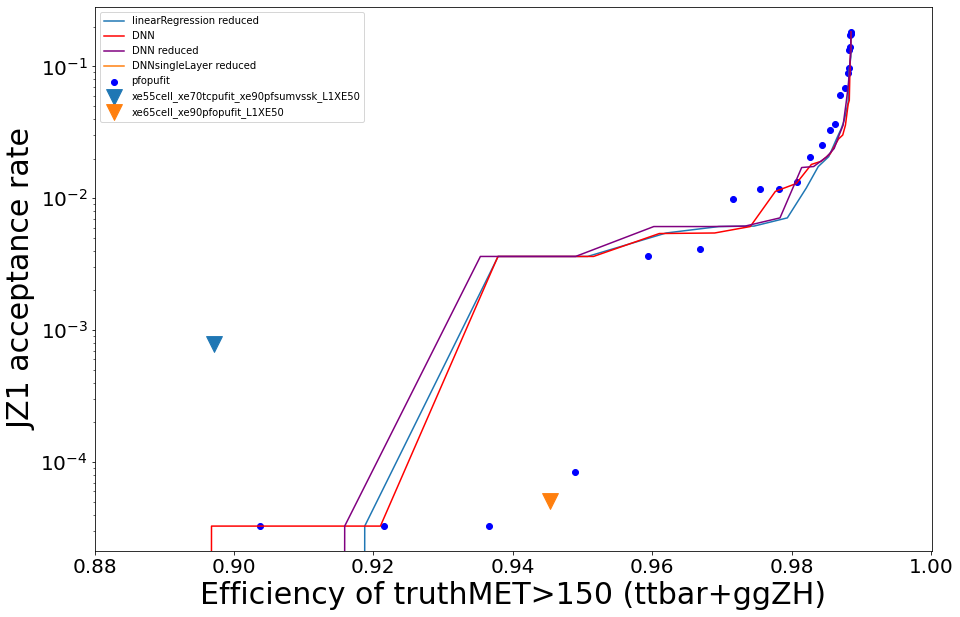

In [61]:
tc_fpr=[]
tc_tpr=[]

pfo_fpr=[]
pfo_tpr=[]


reg_fpr=[]
reg_tpr=[]

regRed_fpr=[]
regRed_tpr=[]

dnn_fpr=[]
dnn_tpr=[]

dnn_red_fpr=[]
dnn_red_tpr=[]

dnn_redS_fpr=[]
dnn_redS_tpr=[]

cutBins=[]
step=5
for i in range(80):
    cut=0+i*step
    cutBins.append(cut)
    pr=checkRates(JZ1xValid,ttZHxValid,"tcpufit.met",cut)
    tc_fpr.append(pr[0])
    tc_tpr.append(pr[1])
    
    pr=checkRates(JZ1xValid,ttZHxValid,"trkmht.met",cut)
    trkmht_fpr.append(pr[0])
    trkmht_tpr.append(pr[1])
    
    pr=checkRates(JZ1xValid,ttZHxValid,"pfopufit.met",cut)
    pfo_fpr.append(pr[0])
    pfo_tpr.append(pr[1])
    
    pr=checkRegressionRates(reg_JZ1predict,JZ1xValid,reg_ttZHpredict,ttZHxValid,cut)
    reg_fpr.append(pr[0])
    reg_tpr.append(pr[1])
    
    pr=checkRegressionRates(regRed_JZ1predict,JZ1xValid,regRed_ttZHpredict,ttZHxValid,cut)
    regRed_fpr.append(pr[0])
    regRed_tpr.append(pr[1])
    
    pr=checkRegressionRates(dnn_JZ1predict,JZ1xValid,dnn_ttZHpredict,ttZHxValid,cut)
    dnn_fpr.append(pr[0])
    dnn_tpr.append(pr[1])   
    
    pr=checkRegressionRates(dnnRed_JZ1predict,JZ1xValid,dnnRed_ttZHpredict,ttZHxValid,cut)
    dnn_red_fpr.append(pr[0])
    dnn_red_tpr.append(pr[1])
    
    pr=checkRegressionRates(dnnRedS_JZ1predict,JZ1xValid,dnnRedS_ttZHpredict,ttZHxValid,cut)
    dnn_redS_fpr.append(pr[0])
    dnn_redS_tpr.append(pr[1])

fig=plt.figure(2,figsize=(15,10))
plt.scatter(pfo_tpr,pfo_fpr,label='pfopufit',color='b')
#plt.plot(reg_tpr, reg_fpr,label='linearRegression')
plt.plot(regRed_tpr, regRed_fpr,label='linearRegression reduced')
plt.plot(dnn_tpr, dnn_fpr,label='DNN',color='r')
#plt.plot(dnn_top10_tpr, dnn_top10_fpr,label='DNNtop10',color='m')
#plt.plot(dnn_top20_tpr, dnn_top20_fpr,label='DNNtop20',color='y')
#plt.plot(dnn_noPhi_tpr, dnn_noPhi_fpr,label='DNNnoPhi',color='gray')
plt.plot(dnn_red_tpr, dnn_red_fpr,label='DNN reduced',color='purple')
plt.plot(dnn_redS_tpr, dnn_redS_fpr,label='DNNsingleLayer reduced')
plt.scatter(cell55tc70vssk90_ttZHeff,cell55tc70vssk90_JZ1rate,label='xe55cell_xe70tcpufit_xe90pfsumvssk_L1XE50',marker='v',s=250)
plt.scatter(cell65pfo90_ttZHeff,cell65pfo90_JZ1rate,label='xe65cell_xe90pfopufit_L1XE50',marker='v',s=250)
plt.ylabel("JZ1 acceptance rate",size=30)
plt.xlabel("Efficiency of truthMET>150 (ttbar+ggZH)",size=30)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
#plt.text(0.945,0.6,r'MC samples with Events passed L1XE50',size=20)
plt.yscale('log')
plt.xlim(0.88,1.0001)
plt.legend(loc='best',prop={'size': 10})
plt.show()
fig.savefig(saveDir+"/ROC_JZ1.pdf")
plt.close(fig)

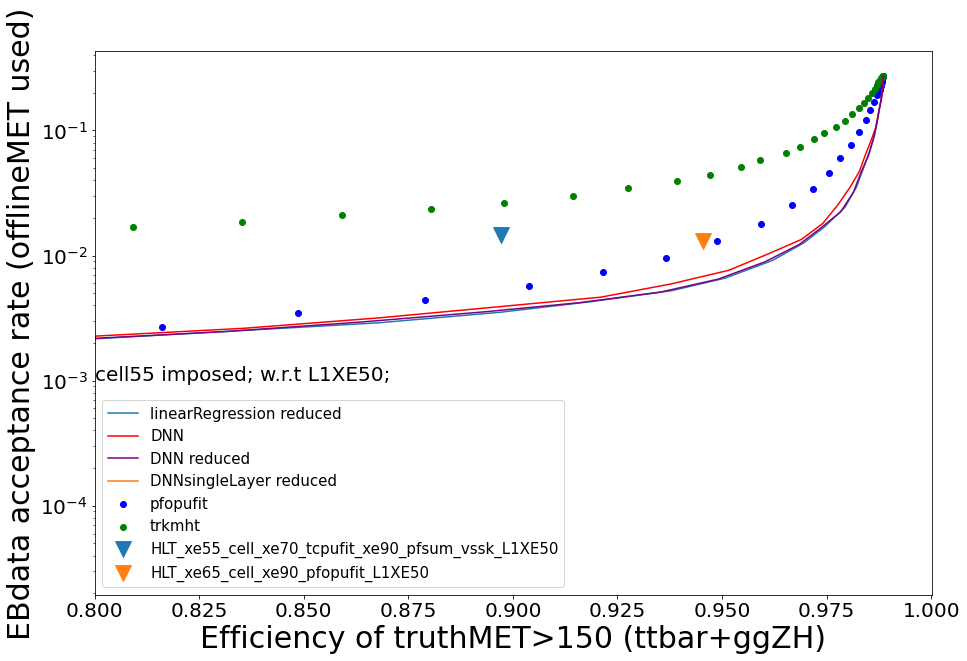

In [66]:
tc_fpr=[]
tc_tpr=[]

pfo_fpr=[]
pfo_tpr=[]

trkmht_fpr=[]
trkmht_tpr=[]

reg_fpr=[]
reg_tpr=[]

regRed_fpr=[]
regRed_tpr=[]

dnn_fpr=[]
dnn_tpr=[]

dnn_red_fpr=[]
dnn_red_tpr=[]


dnn_redS_fpr=[]
dnn_redS_tpr=[]

cutBins=[]
step=5
for i in range(80):
    cut=0+i*step
    cutBins.append(cut)
    pr=checkRates(dataPostL1,ttZHxValid,"tcpufit.met",cut)
    tc_fpr.append(pr[0])
    tc_tpr.append(pr[1])
    
    pr=checkRates(dataPostL1,ttZHxValid,"trkmht.met",cut)
    trkmht_fpr.append(pr[0])
    trkmht_tpr.append(pr[1])
    
    pr=checkRates(dataPostL1,ttZHxValid,"pfopufit.met",cut)
    pfo_fpr.append(pr[0])
    pfo_tpr.append(pr[1])
    
    pr=checkRegressionRates(reg_EBpredict,dataPostL1,reg_ttZHpredict,ttZHxValid,cut)
    reg_fpr.append(pr[0])
    reg_tpr.append(pr[1])
    
    pr=checkRegressionRates(regRed_EBpredict,dataPostL1,regRed_ttZHpredict,ttZHxValid,cut)
    regRed_fpr.append(pr[0])
    regRed_tpr.append(pr[1])
    
    pr=checkRegressionRates(dnn_EBpredict,dataPostL1,dnn_ttZHpredict,ttZHxValid,cut)
    dnn_fpr.append(pr[0])
    dnn_tpr.append(pr[1])

    pr=checkRegressionRates(dnnRed_EBpredict,dataPostL1,dnnRed_ttZHpredict,ttZHxValid,cut)
    dnn_red_fpr.append(pr[0])
    dnn_red_tpr.append(pr[1])
    
    pr=checkRegressionRates(dnnRedS_EBpredict,dataPostL1,dnnRedS_ttZHpredict,ttZHxValid,cut)
    dnn_redS_fpr.append(pr[0])
    dnn_redS_tpr.append(pr[1])
    
fig=plt.figure(2,figsize=(15,10))
plt.scatter(pfo_tpr,pfo_fpr,label='pfopufit',color='b')
plt.scatter(trkmht_tpr,trkmht_fpr,label='trkmht',color='g')
#plt.plot(reg_tpr, reg_fpr,label='linearRegression')
plt.plot(regRed_tpr, regRed_fpr,label='linearRegression reduced')
plt.plot(dnn_tpr, dnn_fpr,label='DNN',color='r')
#plt.plot(dnn_noPhi_tpr, dnn_noPhi_fpr,label='DNNnoPhi',color='gray')
plt.plot(dnn_red_tpr, dnn_red_fpr,label='DNN reduced',color='purple')
plt.plot(dnn_redS_tpr, dnn_redS_fpr,label='DNNsingleLayer reduced')
#plt.plot(dnn_top20_tpr, dnn_top20_fpr,label='DNNtop20',color='y')
plt.scatter(cell55tc70vssk90_ttZHeff,cell55tc70vssk90_EBrate,label='HLT_xe55_cell_xe70_tcpufit_xe90_pfsum_vssk_L1XE50',marker='v',s=250)
plt.scatter(cell65pfo90_ttZHeff,cell65pfo90_EBrate,label='HLT_xe65_cell_xe90_pfopufit_L1XE50',marker='v',s=250)
plt.ylabel("EBdata acceptance rate (offlineMET used)",size=30)
plt.xlabel("Efficiency of truthMET>150 (ttbar+ggZH)",size=30)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
#plt.text(0.945,0.6,r'MC samples with Events passed L1XE50',size=20)
plt.text(0.8,0.001,r'cell55 imposed; w.r.t L1XE50;',size=20)
plt.yscale('log')
plt.xlim(0.8,1.0001)
#plt.ylim(0.01,1.0001)
plt.legend(loc='best',prop={'size': 15})
plt.show()
fig.savefig(saveDir+"/ROC_EB.pdf")
plt.close(fig)

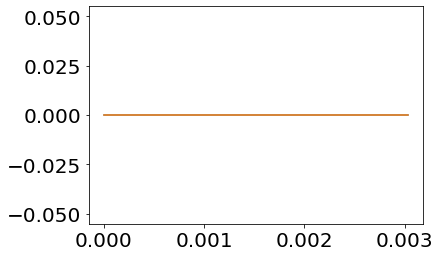

In [68]:
plt.plot(dnn_redS_tpr, dnn_redS_fpr,label='DNNsingleLayer reduced')
plt.show()

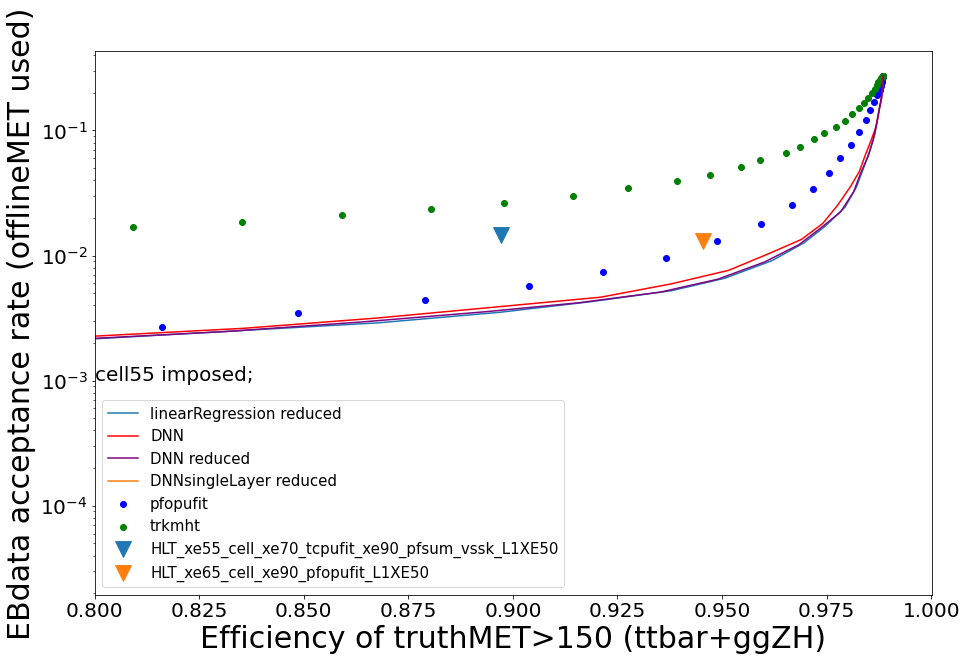

In [65]:
tc_fpr=[]
tc_tpr=[]

pfo_fpr=[]
pfo_tpr=[]

trkmht_fpr=[]
trkmht_tpr=[]

reg_fpr=[]
reg_tpr=[]

regRed_fpr=[]
regRed_tpr=[]

dnn_fpr=[]
dnn_tpr=[]

dnn_red_fpr=[]
dnn_red_tpr=[]


dnn_redS_fpr=[]
dnn_redS_tpr=[]

cutBins=[]
step=5
for i in range(80):
    cut=0+i*step
    cutBins.append(cut)
    pr=checkRates(data_df,ttZHxValid,"tcpufit.met",cut)
    tc_fpr.append(pr[0])
    tc_tpr.append(pr[1])
    
    pr=checkRates(data_df,ttZHxValid,"trkmht.met",cut)
    trkmht_fpr.append(pr[0])
    trkmht_tpr.append(pr[1])
    
    pr=checkRates(data_df,ttZHxValid,"pfopufit.met",cut)
    pfo_fpr.append(pr[0])
    pfo_tpr.append(pr[1])
    
    pr=checkRegressionRates(reg_EBpredict,data_df,reg_ttZHpredict,ttZHxValid,cut)
    reg_fpr.append(pr[0])
    reg_tpr.append(pr[1])
    
    pr=checkRegressionRates(regRed_EBpredict,data_df,regRed_ttZHpredict,ttZHxValid,cut)
    regRed_fpr.append(pr[0])
    regRed_tpr.append(pr[1])
    
    pr=checkRegressionRates(dnn_EBpredict,data_df,dnn_ttZHpredict,ttZHxValid,cut)
    dnn_fpr.append(pr[0])
    dnn_tpr.append(pr[1])

    pr=checkRegressionRates(dnnRed_EBpredict,data_df,dnnRed_ttZHpredict,ttZHxValid,cut)
    dnn_red_fpr.append(pr[0])
    dnn_red_tpr.append(pr[1])
    
        
    pr=checkRegressionRates(dnnRedS_EBpredict,data_df,dnnRedS_ttZHpredict,ttZHxValid,cut)
    dnn_redS_fpr.append(pr[0])
    dnn_redS_tpr.append(pr[1])
    
fig=plt.figure(2,figsize=(15,10))
plt.scatter(pfo_tpr,pfo_fpr,label='pfopufit',color='b')
plt.scatter(trkmht_tpr,trkmht_fpr,label='trkmht',color='g')
#plt.plot(reg_tpr, reg_fpr,label='linearRegression')
plt.plot(regRed_tpr, regRed_fpr,label='linearRegression reduced')
plt.plot(dnn_tpr, dnn_fpr,label='DNN',color='r')
#plt.plot(dnn_noPhi_tpr, dnn_noPhi_fpr,label='DNNnoPhi',color='gray')
plt.plot(dnn_red_tpr, dnn_red_fpr,label='DNN reduced',color='purple')
plt.plot(dnn_redS_tpr, dnn_redS_fpr,label='DNNsingleLayer reduced')
#plt.plot(dnn_top20_tpr, dnn_top20_fpr,label='DNNtop20',color='y')
plt.scatter(cell55tc70vssk90_ttZHeff,cell55tc70vssk90_EBrate,label='HLT_xe55_cell_xe70_tcpufit_xe90_pfsum_vssk_L1XE50',marker='v',s=250)
plt.scatter(cell65pfo90_ttZHeff,cell65pfo90_EBrate,label='HLT_xe65_cell_xe90_pfopufit_L1XE50',marker='v',s=250)
plt.ylabel("EBdata acceptance rate (offlineMET used)",size=30)
plt.xlabel("Efficiency of truthMET>150 (ttbar+ggZH)",size=30)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
#plt.text(0.945,0.6,r'MC samples with Events passed L1XE50',size=20)
plt.text(0.8,0.001,r'cell55 imposed;',size=20)
plt.yscale('log')
plt.xlim(0.8,1.0001)
#plt.ylim(0.01,1.0001)
plt.legend(loc='best',prop={'size': 15})
plt.show()
fig.savefig(saveDir+"/ROC_EB.pdf")
plt.close(fig)

In [ ]:
cell65pfo90_EBrate

In [ ]:
#First determine the DNN cut at that rate:
checkRegressionRates(dnn_EBpredict,dataPostL1,dnn_ttZHpredict,ttZHxValid,111.2)

In [ ]:
checkRegressionRates(dnnRed_EBpredict,dataPostL1,dnnRed_ttZHpredict,ttZHxValid,107.82)

In [ ]:
checkRegressionRates(reg_EBpredict,dataPostL1,reg_ttZHpredict,ttZHxValid,108.6)

In [ ]:
checkRegressionRates(regRed_EBpredict,dataPostL1,regRed_ttZHpredict,ttZHxValid,105.4)

In [ ]:
def getEfficiency(valid,algPassed,truth,cutbins):
    eff=[]
    tmpX=valid[valid[algPassed]==1]
    for i in range(len(cutbins)):
        selected=tmpX[(tmpX['cell.met']>cellCut)&(tmpX[truth]<(cutbins[i]+bar))&(tmpX[truth]>(cutbins[i]-bar))]['weight'].sum()
        All=valid[(valid[truth]>(cutbins[i]-bar))&(valid[truth]<(cutbins[i]+bar))]['weight'].sum()
        eff.append(selected/All)
    return eff

def getEfficiencyRegression(valid,algCut,algPredict,truth,cutbins):
    eff=[]
    tmpX=valid[algPredict>=algCut]
    for i in range(len(cutbins)):
        selected=tmpX[(tmpX['cell.met']>cellCut)&(tmpX[truth]<(cutbins[i]+bar))&(tmpX[truth]>(cutbins[i]-bar))]['weight'].sum()
        All=valid[(valid[truth]>(cutbins[i]-bar))&(valid[truth]<(cutbins[i]+bar))]['weight'].sum()
        eff.append(selected/All)
    return eff

In [ ]:
cutbins=[]
cutbinsBar=[]
bar=5
counter=bar
for i in range(30):
    cutbins.append(counter)
    cutbinsBar.append(bar)
    counter+=2*bar   
    

In [ ]:
L1_XE50_eff=getEfficiency(ttZHxValid,"L1_XE50.isPassed","MET",cutbins)
HLT_xe100_pfopufit_L1XE50_eff=getEfficiency(ttZHxValid,"HLT_xe100_pfopufit_L1XE50.isPassed","MET",cutbins)
HLT_xe110_tcpufit_L1XE50_eff=getEfficiency(ttZHxValid,"HLT_xe110_tcpufit_L1XE50.isPassed","MET",cutbins)
HLT_xe100_trkmht_xe85_tcpufit_xe65_cell_L1XE50_eff=getEfficiency(ttZHxValid,"HLT_xe100_trkmht_xe85_tcpufit_xe65_cell_L1XE50.isPassed","MET",cutbins)
dnn_eff=getEfficiencyRegression(ttZHxValid,111.2,dnn_ttZHpredict,'MET',cutbins)
dnnRed_eff=getEfficiencyRegression(ttZHxValid,107.82,dnnRed_ttZHpredict,'MET',cutbins)
reg_eff=getEfficiencyRegression(ttZHxValid,108.6,reg_ttZHpredict,'MET',cutbins)
regRed_eff=getEfficiencyRegression(ttZHxValid,105.4,regRed_ttZHpredict,'MET',cutbins)

In [ ]:
fig=plt.figure(40,figsize=(15,10))
plt.errorbar(cutbins,regRed_eff,xerr=cutbinsBar,color='y',label='L1XE50+linear regression Reduced',fmt='1',capsize=5)
plt.errorbar(cutbins,reg_eff,xerr=cutbinsBar,color='k',label='L1XE50+linear regression',fmt='1',capsize=5)
plt.errorbar(cutbins,dnnRed_eff,xerr=cutbinsBar,color='m',label='L1XE50+DNN reduced',fmt='.',capsize=5)
plt.errorbar(cutbins,dnn_eff,xerr=cutbinsBar,color='r',label='L1XE50+DNN',fmt='.',capsize=5)
plt.ylabel("Efficiency",size=30)
plt.xlabel("TruthMET",size=30)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
#plt.text(250,0.3,r'MC ggZH125',size=30)
#plt.text(250,0.3,r'MC $t\overline{t}$ nonAllHad',size=30)
plt.axvline(x=150,linestyle='--')
plt.text(150,0.4,r'$t\overline{t}$ nonAllHad+ggZH125; L1XE50',size=20)
plt.text(150,0.2,r'Equal rate in EBdata $\approx 0.013$ (W.o cell 55)',size=20)
plt.text(150,0.3,r'cell55 imposed; w.r.t L1XE50;',size=20)
plt.legend(loc='best',prop={'size': 15})
plt.show()
fig.savefig(saveDir+"/effPt.pdf")
plt.close(fig)

In [ ]:
def getMuEfficiency(valid,algPassed,truth,mu,cutbins):
    eff=[]
    tmpX=valid[(valid[algPassed]==1)&(valid[truth]>=150)]
    signalEvents=valid[valid[truth]>=150]
    for i in range(len(cutbins)):
        selected=tmpX[(tmpX['cell.met']>cellCut)&(tmpX[mu]<(cutbins[i]+bar))&(tmpX[mu]>(cutbins[i]-bar))]['weight'].sum()
        All=signalEvents[(signalEvents['cell.met']>cellCut)&(signalEvents[mu]>(cutbins[i]-bar))&(signalEvents[mu]<(cutbins[i]+bar))]['weight'].sum()
        eff.append(selected/(All+1e-7))
    return eff

def getMuEfficiencyRegression(valid,algCut,algPredict,truth,mu,cutbins):
    eff=[]
    signalEvents=valid[valid[truth]>=150]
    tmpX=valid[(algPredict>=algCut)&(valid[truth]>=150)]
    for i in range(len(cutbins)):
        selected=tmpX[(tmpX['cell.met']>cellCut)&(tmpX[mu]<(cutbins[i]+bar))&(tmpX[mu]>(cutbins[i]-bar))]['weight'].sum()
        All=signalEvents[(signalEvents['cell.met']>cellCut)&(signalEvents[mu]>(cutbins[i]-bar))&(signalEvents[mu]<(cutbins[i]+bar))]['weight'].sum()
        eff.append(selected/(All+1e-7))
    return eff

In [ ]:
mubins=[]
mubinsBar=[]
bar=2.5
counter=40
for i in range(7):
    mubins.append(counter)
    mubinsBar.append(bar)
    counter+=2*bar   
    
muName='ActualInteractionsPerCrossing'
L1_XE50_eff=getMuEfficiency(ttZHxValid,"L1_XE50.isPassed","MET",muName,mubins)
HLT_xe100_pfopufit_L1XE50_eff=getMuEfficiency(ttZHxValid,"HLT_xe100_pfopufit_L1XE50.isPassed","MET",muName,mubins)
HLT_xe110_tcpufit_L1XE50_eff=getMuEfficiency(ttZHxValid,"HLT_xe110_tcpufit_L1XE50.isPassed","MET",muName,mubins)
HLT_xe100_trkmht_xe85_tcpufit_xe65_cell_L1XE50_eff=getMuEfficiency(ttZHxValid,"HLT_xe100_trkmht_xe85_tcpufit_xe65_cell_L1XE50.isPassed","MET",muName,mubins)

dnn_eff=getMuEfficiencyRegression(ttZHxValid,111.2,dnn_ttZHpredict,'MET',muName,mubins)
dnnRed_eff=getMuEfficiencyRegression(ttZHxValid,107.82,dnnRed_ttZHpredict,'MET',muName,mubins)
reg_eff=getMuEfficiencyRegression(ttZHxValid,108.6,reg_ttZHpredict,'MET',muName,mubins)
regRed_eff=getMuEfficiencyRegression(ttZHxValid,105.4,regRed_ttZHpredict,'MET',muName,mubins)

In [ ]:
fig=plt.figure(6,figsize=(15,10))
plt.errorbar(mubins,reg_eff,xerr=mubinsBar,color='k',label='L1XE50+linear regression',fmt='1',capsize=5)
plt.errorbar(mubins,regRed_eff,xerr=mubinsBar,color='y',label='L1XE50+linear regression reduced',fmt='1',capsize=5)
plt.errorbar(mubins,dnn_eff,xerr=mubinsBar,color='r',label='L1XE50+DNN',fmt='.',capsize=5)
plt.errorbar(mubins,dnnRed_eff,xerr=mubinsBar,color='m',label='L1XE50+DNN reduced',fmt='.',capsize=5)
plt.ylabel("Efficiency",size=30)
plt.xlabel("Actual interaction per crossing",size=30)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.ylim(0.8,1.0)
plt.text(52,0.89,r'$t\overline{t}$ nonAllHad+ggZH125; L1XE50',size=20)
plt.text(52,0.85,r'Equal rate in EBdata $\approx 0.013$ (W.o cell 55)',size=20)
plt.text(52,0.87,r'cell55 imposed; w.r.t L1XE50;',size=20)
plt.legend(loc='best',prop={'size': 15})
plt.show()
fig.savefig(saveDir+"/effmu.pdf")
plt.close(fig)

In [ ]:
dnn_model_reducedList.name

In [ ]:
tf.__version__

In [ ]:
import onnx
import tf2onnx
import onnxruntime as ort

In [ ]:
# Use from_function for tf functions
redSpec = (tf.TensorSpec((None, 12), tf.double, name="input"),)
model_proto, _ = tf2onnx.convert.from_keras(dnn_model_reducedList,input_signature=redSpec,opset=13,
                                            output_path="DNNred.onnx")

In [ ]:
output_names = [n.name for n in model_proto.graph.output]

In [ ]:
output_names

In [ ]:
providers = ['CPUExecutionProvider']
m = ort.InferenceSession("DNNred.onnx",providers=providers)

In [ ]:
onnx_pred = m.run(output_names, {"input": ttZHxValid[reducedList].to_numpy()})

In [ ]:
onnx_pred

In [ ]:
diff=onnx_pred-dnn_model_reducedList.predict(ttZHxValid[reducedList])

In [ ]:
diff.mean()

In [ ]:
diff.std()

lwtnn

In [ ]:
arch =dnn_model_reducedList.to_json()

In [ ]:
with open('architecture.json', 'w') as arch_file:
    arch_file.write(arch)
# now save the weights as an HDF5 file
dnn_model_reducedList.save_weights('weights.h5')